# Generalization

Generalization is nothing but modeling the network such that it should not overfit the training data and should be able to generalize more precisely the new unseen test data.

This depends on two parameters.
* complexity of the model
* performance on training set.

This can be achieved by dividing the given data into two sets. Training set and testing set.

For better performance, divide the training set further into training set and validation set. train the model using the training set and validate the models on the validation sets. choose the model which performs better on the validation set to and test it using the test set.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [15]:
california_housing_dataframe = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv', sep=',')
california_housing_dataframe =  california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16822,-123.2,40.5,27.0,1573.0,361.0,847.0,330.0,1.9,49600.0
2926,-117.8,33.8,15.0,3764.0,510.0,1448.0,468.0,8.7,410500.0
16366,-122.5,38.0,32.0,2390.0,336.0,810.0,354.0,8.6,500001.0
9827,-119.7,34.4,17.0,1826.0,544.0,1325.0,532.0,1.3,253600.0
1467,-117.2,32.8,52.0,1495.0,230.0,459.0,190.0,8.2,500001.0


In [0]:
def preprocess_features(chd):
  '''
  chd - califonia housing dataframe
  returns - selected features along with syntetic feature in a single df
  '''

  selected_features = chd[["latitude", "longitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]]

  processed_features = selected_features.copy()

  processed_features['rooms_per_person'] = chd['total_rooms'] / chd['population']

  return processed_features

In [0]:
def preprocess_targets(chd):
  '''
  chd - california housing department
  returns - target feature as df.
  '''

  processed_target = pd.DataFrame()
  processed_target['median_house_value'] = chd['median_house_value'] / 1000.0

  return processed_target

In [16]:
# training set

training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.head()

training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.head()
training_examples.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
16822,40.5,-123.2,27.0,1573.0,361.0,847.0,330.0,1.9,1.9
2926,33.8,-117.8,15.0,3764.0,510.0,1448.0,468.0,8.7,2.6
16366,38.0,-122.5,32.0,2390.0,336.0,810.0,354.0,8.6,3.0
9827,34.4,-119.7,17.0,1826.0,544.0,1325.0,532.0,1.3,1.4
1467,32.8,-117.2,52.0,1495.0,230.0,459.0,190.0,8.2,3.3


In [17]:
# validation examples

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.head()

validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.head()

,median_house_value
8173,500.0
484,162.3
12432,258.3
4097,257.2
10624,130.6


[]

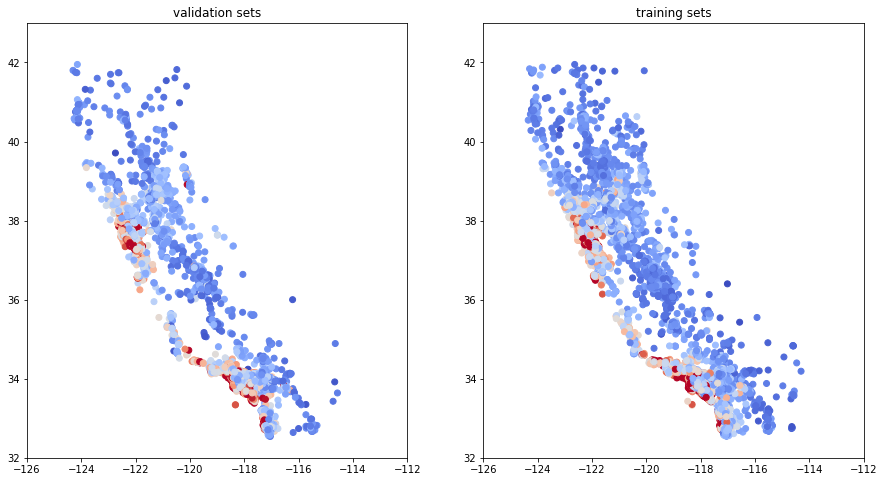

In [18]:
# plotting latitude/longitude with median house value as c

plt.figure(figsize=(15,8))

ax = plt.subplot(1,2,1)

ax.set_title('validation sets')
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(validation_examples['longitude'], validation_examples['latitude'], cmap='coolwarm', c=(validation_targets['median_house_value']/validation_targets['median_house_value'].max()))

ax = plt.subplot(1,2,2)
ax.set_title('training sets')
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(training_examples['longitude'], training_examples['latitude'], cmap='coolwarm', c=(training_targets['median_house_value']/training_targets['median_house_value'].max()))

plt.plot()

In [0]:
# define input function

def my_input_fn(features, targets, batch_size=1, shuffle=True, epochs=None):
  '''
  features - input features.
  targets - target labels
  batch_size - number of batches of examples for training
  shuffle - shuffle the examples
  epochs - number of times to repeat
  '''

  features = {key:np.array(value) for key,value in dict(features).items()} 

  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(epochs)

  if shuffle:
    ds = ds.shuffle(10000)

  features, targets = ds.make_one_shot_iterator().get_next()

  return features, targets

In [0]:
# since multiple features are used, we need to create a feature column

def feature_column(input_features):
  '''returns feature column'''

  return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [0]:
def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
  """Trains a linear regression model of multiple features.  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_column(training_examples), optimizer=my_optimizer)
  
  # 1. Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'], batch_size=1, shuffle=True, epochs=None)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'], shuffle=False, epochs=1)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets['median_house_value'], shuffle=False, epochs=1)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])

    validation_predictions = linear_regressor.predict(predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 216.13
  period 01 : 199.20
  period 02 : 185.50
  period 03 : 176.64
  period 04 : 169.80
  period 05 : 167.31
  period 06 : 165.57
  period 07 : 165.41
  period 08 : 166.03
  period 09 : 168.09
Model training finished.


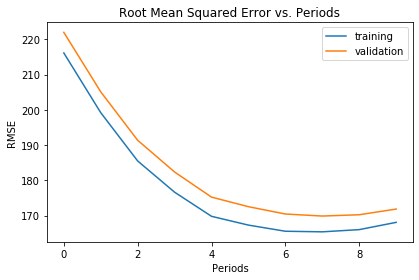

In [26]:
linear_regressor = train_model(learning_rate=0.00003, steps=500, batch_size=5, training_examples=training_examples, training_targets=training_targets, validation_examples=validation_examples, validation_targets=validation_targets)

In [30]:
# testing on test data

california_test_dataframe = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv', sep=',')

test_examples = preprocess_features(california_test_dataframe)
test_targets = preprocess_targets(california_test_dataframe)

predict_test_fn = lambda: my_input_fn(test_examples, test_targets['median_house_value'], shuffle=False, epochs=1)

predict_test_data = linear_regressor.predict(predict_test_fn)
predict_test_data = np.array([item['predictions'][0] for item in predict_test_data])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(predict_test_data, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 162.26
